# Node and Edge Embeddings - Using GNN

In [1]:
import pickle
import torch
import time
import random
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from functions import AMLDataPreprocessing
from pandas import Timestamp
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![Screenshot 2024-05-22 at 18.37.26.png](<attachment:Screenshot 2024-05-22 at 18.37.26.png>)
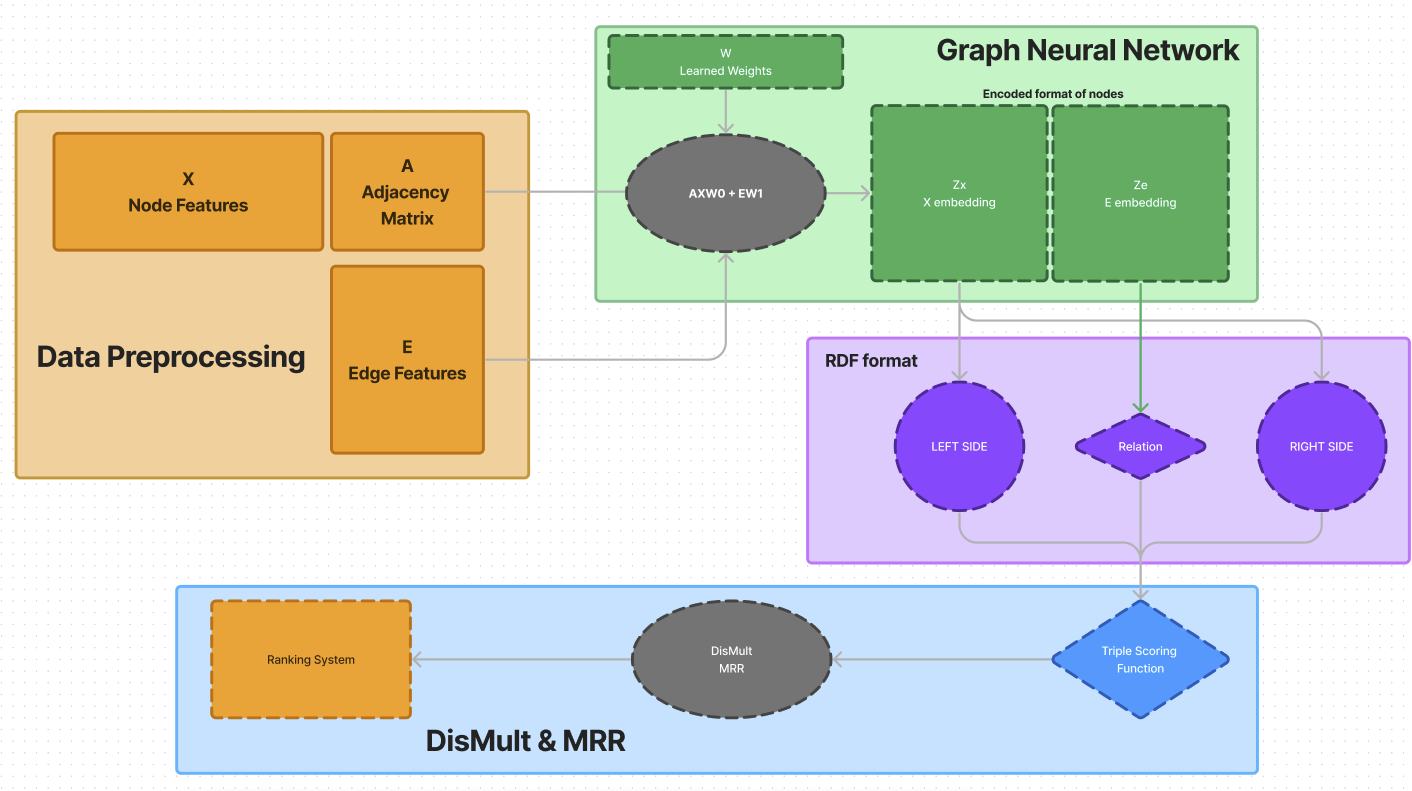

# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

In [2]:
# with open("graph_data.pickle", "rb") as f:
#     loaded_data = pickle.load(f)
# # fraudulent transaction:
# fraudulent_transaction = (labels==1).nonzero().squeeze()
# print(fraudulent_transaction)
# print(input_data)

# PROCESS DATA directly

Data Head - <bound method NDFrame.head of              Timestamp  From Bank    Account  To Bank  Account.1  \
0     2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1     2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2     2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3     2022/09/01 00:02         12  8000F5030       12  8000F5030   
4     2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                ...        ...        ...      ...        ...   
4994  2022/09/01 00:15      11318  80087D580    11318  80087D580   
4995  2022/09/01 00:02       1674  80087D1B0     1674  80087D1B0   
4996  2022/09/01 00:19        220  80087EA60      220  80087EA60   
4997  2022/09/01 00:19       2843  8008789D0     2843  8008789D0   
4998  2022/09/01 00:29       1674  80087AC10     1674  80087AC10   

      Amount Received Receiving Currency  Amount Paid Payment Currency  \
0             3697.34          US Dollar      3697.34        US Dol

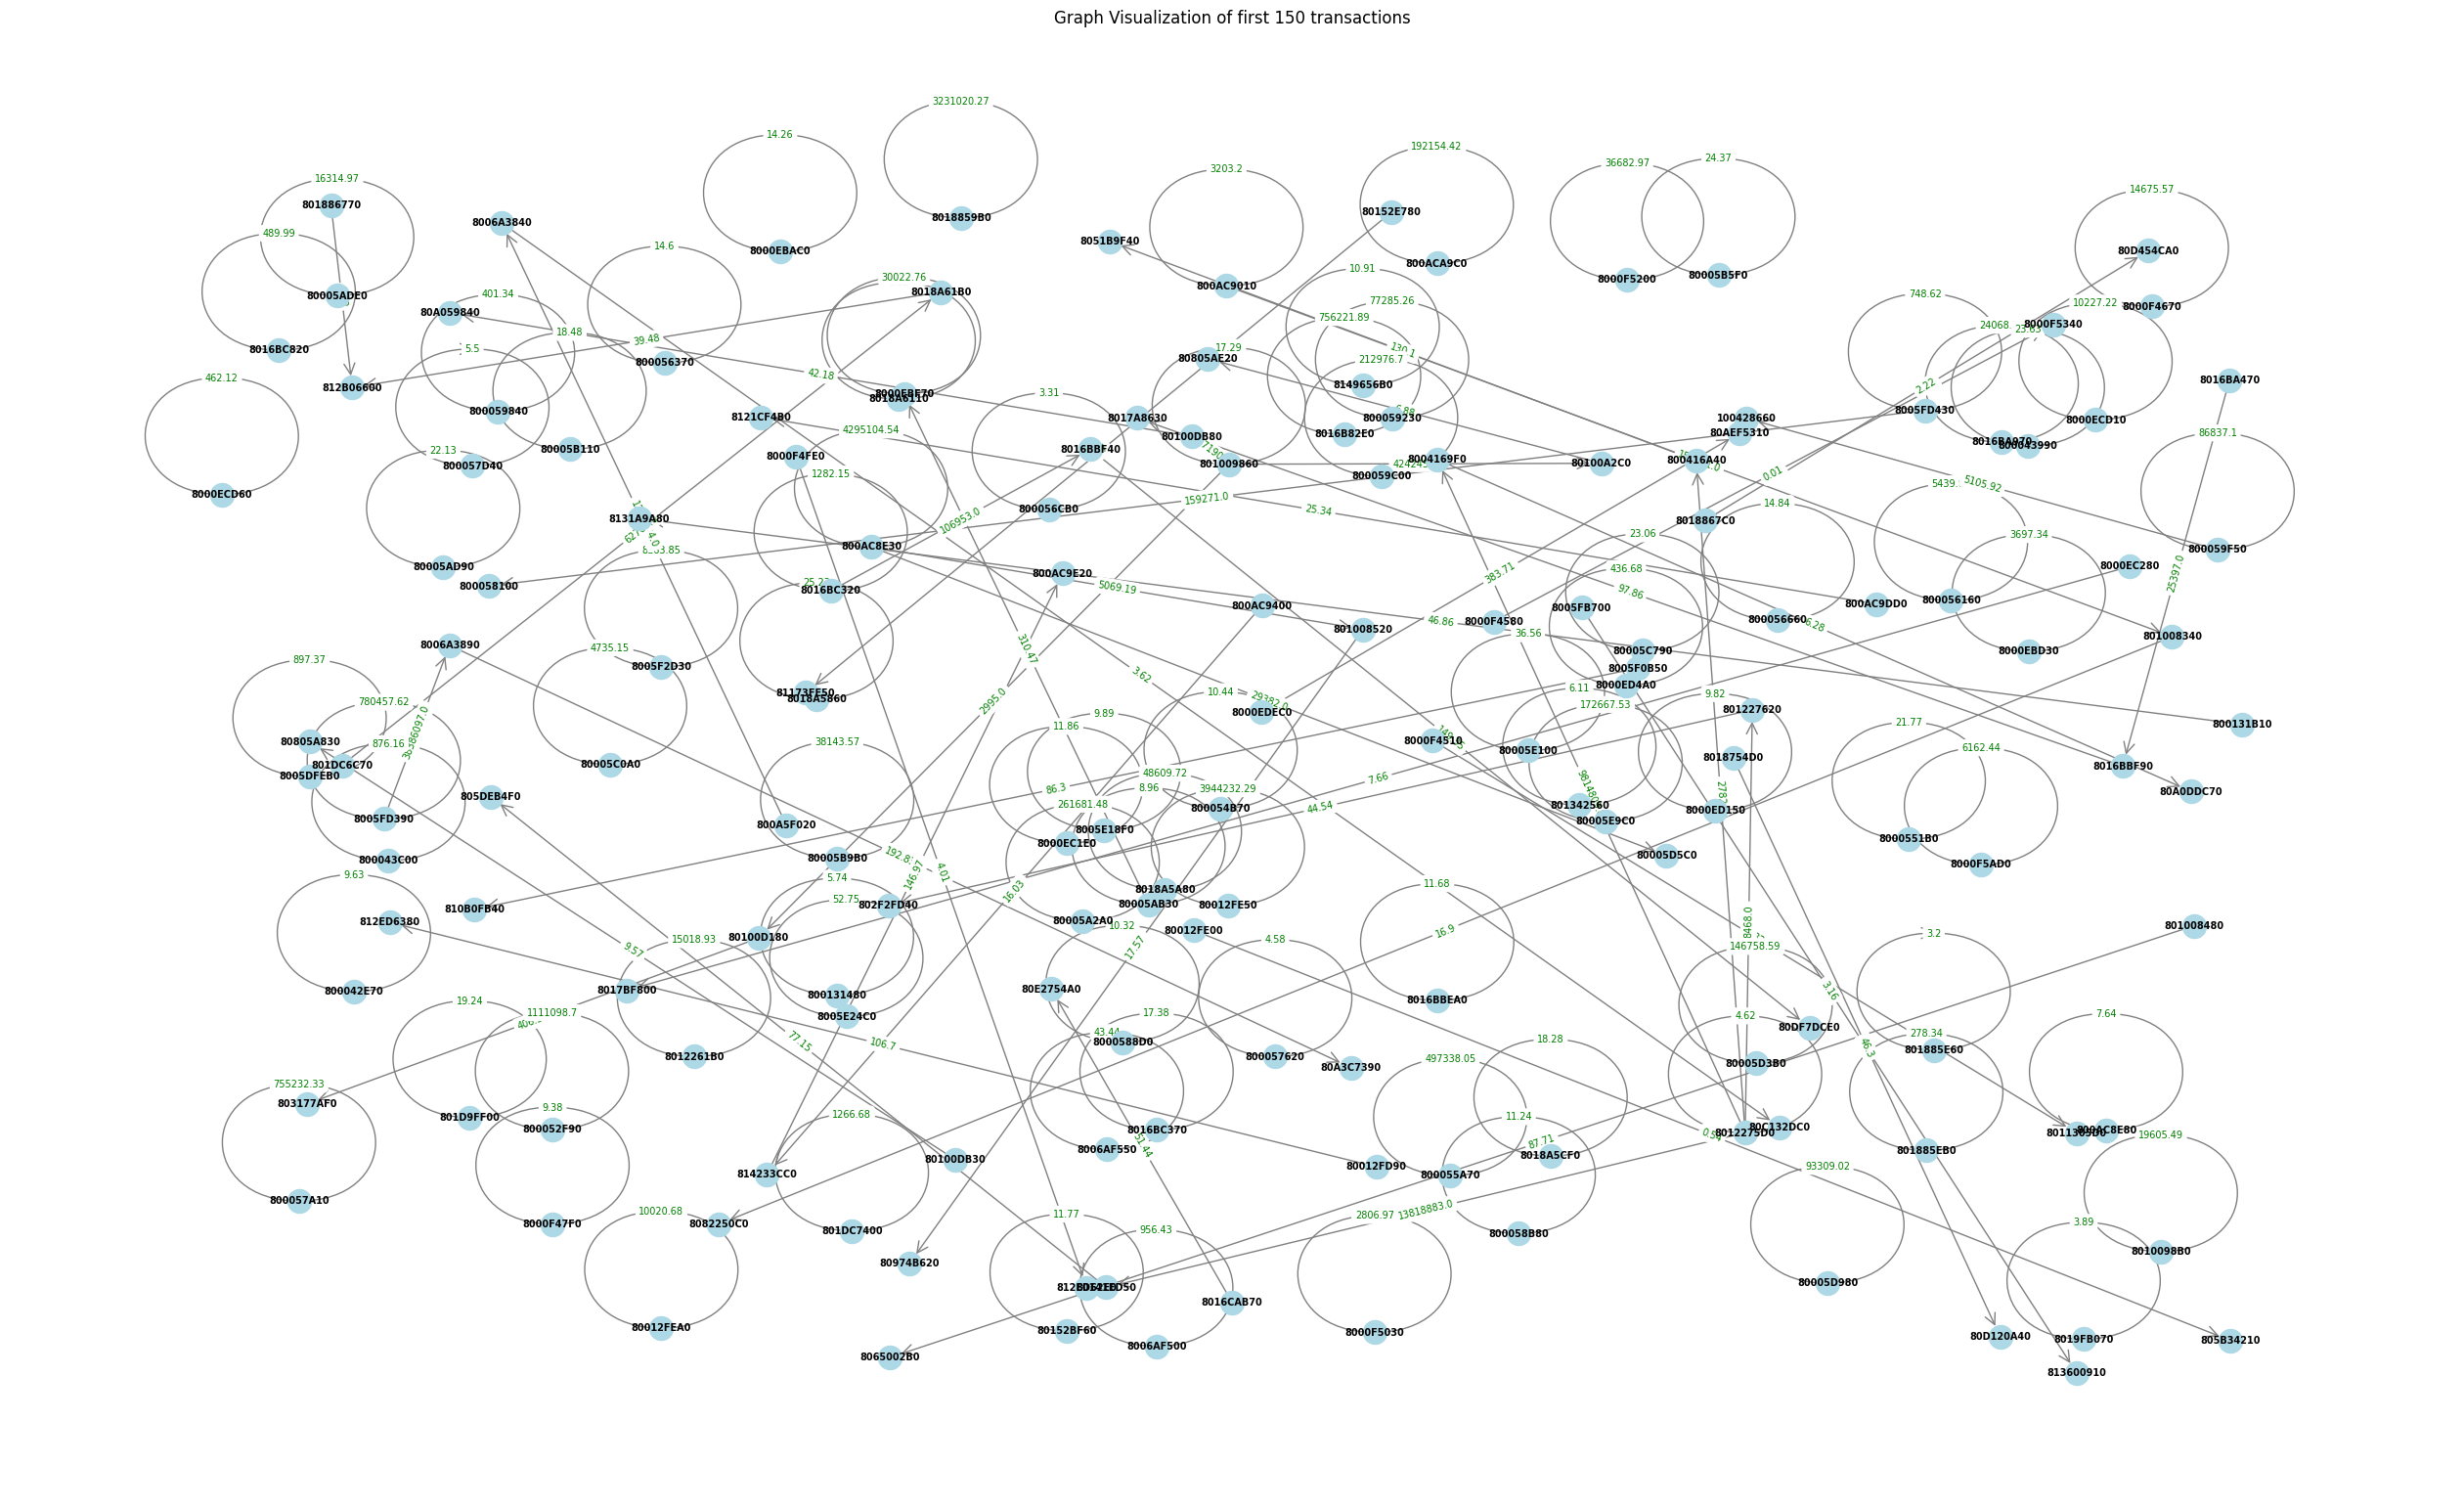

In [3]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_3.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
input_data, graph_full, x, y, labels, links, edges_amount, node_features, edges_features = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)

adjacency_matrix = torch.from_numpy(nx.adjacency_matrix(graph_full).todense()).to(torch.float)

# GRAPH NEURAL NETWORKS

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing


In [5]:
# class GNNLayer(MessagePassing):
#     def __init__(self, node_features, edge_features, hidden_channels):
#         super(GNNLayer, self).__init__(aggr='add')
        
#         self.node_features = node_features
#         self.edge_features = edge_features
#         self.hidden_channels = hidden_channels
        
#         # Learnable parameters
#         self.weight_node = nn.Parameter(torch.Tensor(node_features, hidden_channels))
#         self.weight_edge = nn.Parameter(torch.Tensor(edge_features, hidden_channels))
        
#         self.reset_parameters()
        
#     def reset_parameters(self):
#         nn.init.xavier_uniform_(self.weight_node)
#         nn.init.xavier_uniform_(self.weight_edge)
        
#     def forward(self, x, edge_index, edge_attr):
#         # Add self-loops to the adjacency matrix.
#         # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
#         # # Calculate normalization coefficients.
#         # row, col = edge_index
#         # deg = degree(row, x.size(0), dtype=x.dtype)
#         # deg_inv_sqrt = deg.pow(-0.5)
#         # norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
#         # Message passing
#         return self.propagate(edge_index, x=x, edge_attr=edge_attr)
    
#     def message(self, x_j, edge_index, edge_attr):
#         # AXW0 + EW1
#         # print(norm.view(-1, 1).size())
#         adj_matrix = torch.zeros((x_j.size(0), x_j.size(0)), device=x_j.device)
#         adj_matrix[edge_index[0], edge_index[1]] = 1  # Assuming edge_index is of shape (2, num_edges)

#         print("nodes -- " + str(x_j.size()))
#         print("adj.matrix -- " + str(adj_matrix.size()))
#         print(self.weight_node)
        
#         print("edges -- " + str(edge_attr.size()))
#         print(self.weight_edge)

#         return torch.matmul(adj_matrix, x_j) @ self.weight_node + torch.matmul(edge_attr, self.weight_edge)

#         # return norm.view(-1, 1) * torch.matmul(x_j, self.weight_node) + torch.matmul(edge_attr, self.weight_edge)
    
#     def update(self, aggr_out):
#         return aggr_out

    
# class GNNModel(nn.Module):
#     def __init__(self, node_features, edge_features, hidden_channels, out_channels):
#         super(GNNModel, self).__init__()
#         # self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)
#         # self.conv2 = GNNLayer(hidden_channels, hidden_channels, out_channels)

#         # GCN for NODES
#         self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)
#         self.conv2 = GNNLayer(hidden_channels, hidden_channels, 128)
#         self.conv3 = GNNLayer(128, 128, 256)
#         self.conv4 = GNNLayer(256, 256, 128)
#         self.conv5 = GNNLayer(128, 128, hidden_channels)
#         self.conv6 = GNNLayer(hidden_channels, hidden_channels, out_channels)

#         self.relu = nn.ReLU()

#     def forward(self, x, edge_index, edge_attr):
#         # Two GNN layers with ReLU activation in between.
#         x = self.relu(self.conv1(x, edge_index, edge_attr))
#         x = self.relu(self.conv2(x, edge_index, edge_attr))
#         x = self.relu(self.conv3(x, edge_index, edge_attr))
#         x = self.relu(self.conv4(x, edge_index, edge_attr))
#         x = self.relu(self.conv5(x, edge_index, edge_attr))
#         x = self.conv6(x, edge_index, edge_attr)
        
#         return x

In [6]:
input_data.edge_attr.size()

torch.Size([4999, 26])

In [7]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GNNLayer(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(GNNLayer, self).__init__(aggr='add')
        
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_channels = hidden_channels
        
        # Learnable parameters
        self.weight_node = nn.Parameter(torch.Tensor(node_features, hidden_channels))
        self.weight_edge = nn.Parameter(torch.Tensor(edge_features, hidden_channels))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_node)
        nn.init.xavier_uniform_(self.weight_edge)
        
    def forward(self, x, edge_index, edge_attr):
        # AXW0 + EW1
        global adjacency_matrix
        self.adjacency_matrix = adjacency_matrix
        # adj_matrix = torch.zeros((x.size(0), x.size(0)), device=x.device)
        # adj_matrix[edge_index[0], edge_index[1]] = 1  # Assuming edge_index is of shape (2, num_edges)

        axw = torch.matmul(self.adjacency_matrix, x) @ self.weight_node
        ew = torch.matmul(edge_attr, self.weight_edge)

        # print("-----------------")
        # print(x.size())
        # print(self.adjacency_matrix.size())
        # print(self.weight_node.size())
        # print(edge_attr.size())
        # print(self.weight_edge.size())
        
        # print(axw.size())
        # print(ew.size())

        return axw, ew

    def update(self, aggr_out):
        return aggr_out
    
class GNNModel(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, out_channels):
        super(GNNModel, self).__init__()

        self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)
        self.conv2 = GNNLayer(hidden_channels, hidden_channels, 128)
        self.conv3 = GNNLayer(128, 128, 256)
        self.conv4 = GNNLayer(256, 256, 128)
        self.conv5 = GNNLayer(128, 128, hidden_channels)
        self.conv6 = GNNLayer(hidden_channels, hidden_channels, out_channels)

        # Decoder for node features
        self.decoder_x = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, node_features)
        )

        # Decoder for edge features
        self.decoder_e = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, edge_features)
        )

        self.relu = nn.ReLU()

    def forward(self, x, edge_index, edge_attr):
        # Two GNN layers with ReLU activation in between.
        axw1, ew1 = self.conv1(x, edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv1.hidden_channels)
        axw2, ew2 = self.conv2(self.relu(axw1), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv2.hidden_channels)
        axw3, ew3 = self.conv3(self.relu(axw2), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv3.hidden_channels)
        axw4, ew4 = self.conv4(self.relu(axw3), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv4.hidden_channels)
        axw5, ew5 = self.conv5(self.relu(axw4), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv5.hidden_channels)
        axw6, ew6 = self.conv6(self.relu(axw5), edge_index, edge_attr)
        edge_attr = self.update_edge_attr(edge_attr, self.conv6.hidden_channels)
        
        return axw6, ew6 # returning x and e embeddings

    def update_edge_attr(self, edge_attr, new_channels):
        # Update edge attributes to have 'new_channels'
        # Assuming edge_attr is a tensor of shape (num_edges, num_edge_features)
        num_edge_features = edge_attr.size(1)
        
        if new_channels > num_edge_features:
            # Pad with zeros to match new_channels
            updated_edge_attr = torch.cat((edge_attr, torch.zeros((edge_attr.size(0), new_channels - num_edge_features), device=edge_attr.device)), dim=1)
        else:
            # Keep only the first new_channels channels
            updated_edge_attr = edge_attr[:, :new_channels]
        
        return updated_edge_attr

In [12]:
from torch_geometric.loader import DataLoader

learning_rate = 0.01
hidden_channels = 64
out_channels = 32

model = GNNModel(node_features=input_data.x.size(1), edge_features=input_data.edge_attr.size(1), hidden_channels=hidden_channels, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

def train(data): # using reconstruction loss
    model.train()
    optimizer.zero_grad()
    x_embedding, e_embedding = model(input_data.x, input_data.edge_index, input_data.edge_attr)
    
    # Reconstruction loss using MSE
    reconstruction_loss = nn.MSELoss()
    reconstructed_x = model.decoder_x(x_embedding)  # Assuming you have a decoder for x
    reconstructed_e = model.decoder_e(e_embedding)  # Assuming you have a decoder for e
    loss_x = reconstruction_loss(reconstructed_x, input_data.x)
    loss_e = reconstruction_loss(reconstructed_e, input_data.edge_attr)
    
    # Total loss
    loss = loss_x + loss_e
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), x_embedding, e_embedding

In [13]:
# Continue training loop from provided script
epochs = 600
losses = []

all_x_embeddings = []
all_e_embeddings = []

for epoch in range(epochs):
    loss, x_embedding, e_embedding = train(input_data)
    losses.append(loss)
    all_x_embeddings.append(x_embedding.detach().cpu().numpy())
    all_e_embeddings.append(e_embedding.detach().cpu().numpy())
    print(f'Epoch {epoch}, Total Loss: {loss}')


Epoch 0, Total Loss: 1.1188763468234752e+17
Epoch 1, Total Loss: 9.803593565601792e+16
Epoch 2, Total Loss: 8.589438952774042e+16
Epoch 3, Total Loss: 7.343678534608486e+16
Epoch 4, Total Loss: 5.957814135763763e+16
Epoch 5, Total Loss: 4.447765482019226e+16
Epoch 6, Total Loss: 2.956780255366349e+16
Epoch 7, Total Loss: 1.6188179488964608e+16
Epoch 8, Total Loss: 5742493144449024.0
Epoch 9, Total Loss: 915606362652672.0
Epoch 10, Total Loss: 5527759275163648.0
Epoch 11, Total Loss: 1.422786836824064e+16
Epoch 12, Total Loss: 1.8544169840541696e+16
Epoch 13, Total Loss: 1.6277519103688704e+16
Epoch 14, Total Loss: 1.0711586159198208e+16
Epoch 15, Total Loss: 5137891671932928.0
Epoch 16, Total Loss: 1483163339587584.0
Epoch 17, Total Loss: 382011336294400.0
Epoch 18, Total Loss: 1179454390927360.0
Epoch 19, Total Loss: 2766214489178112.0
Epoch 20, Total Loss: 4342437958909952.0
Epoch 21, Total Loss: 5440539226800128.0
Epoch 22, Total Loss: 5890649651937280.0
Epoch 23, Total Loss: 563303

In [19]:
! pip3 install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 8.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.2 MB/s eta 0:00:00


In [20]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import FOAF, XSD

# Function to create RDF triples and save them
def save_rdf_triples(node_embeddings, edge_embeddings, edge_index, file_name="graph.rdf"):
    g = Graph()
    
    for i in range(edge_index.size(1)):
        head_idx = edge_index[0, i].item()
        tail_idx = edge_index[1, i].item()
        
        head_embedding = node_embeddings[head_idx]
        tail_embedding = node_embeddings[tail_idx]
        relation_embedding = edge_embeddings[i]
        
        head_uri = URIRef(f"http://example.org/node/{head_idx}")
        tail_uri = URIRef(f"http://example.org/node/{tail_idx}")
        relation_uri = URIRef(f"http://example.org/relation/{i}")
        
        g.add((head_uri, RDF.type, FOAF.Person))  # assuming nodes are people
        g.add((tail_uri, RDF.type, FOAF.Person))  # assuming nodes are people
        
        # Add node embeddings as literals
        for dim, value in enumerate(head_embedding):
            g.add((head_uri, URIRef(f"http://example.org/embedding/dim_{dim}"), Literal(value.item(), datatype=XSD.float)))
        for dim, value in enumerate(tail_embedding):
            g.add((tail_uri, URIRef(f"http://example.org/embedding/dim_{dim}"), Literal(value.item(), datatype=XSD.float)))
        
        # Add relation embeddings as literals
        for dim, value in enumerate(relation_embedding):
            g.add((relation_uri, URIRef(f"http://example.org/relation_embedding/dim_{dim}"), Literal(value.item(), datatype=XSD.float)))
        
        # Add the relation (edge)
        g.add((head_uri, relation_uri, tail_uri))
    
    # Save the graph to an RDF file
    g.serialize(destination=file_name, format='xml')

# After training
# Example: Assuming final x_embedding and e_embedding are available after training
final_x_embedding = x_embedding.detach().cpu().numpy()  # node embeddings
final_e_embedding = e_embedding.detach().cpu().numpy()  # edge embeddings

# Save RDF triples
save_rdf_triples(final_x_embedding, final_e_embedding, input_data.edge_index)


ValueError: This graph cannot be serialized to a strict format because there is no valid way to shorten http://example.org/relation/4105

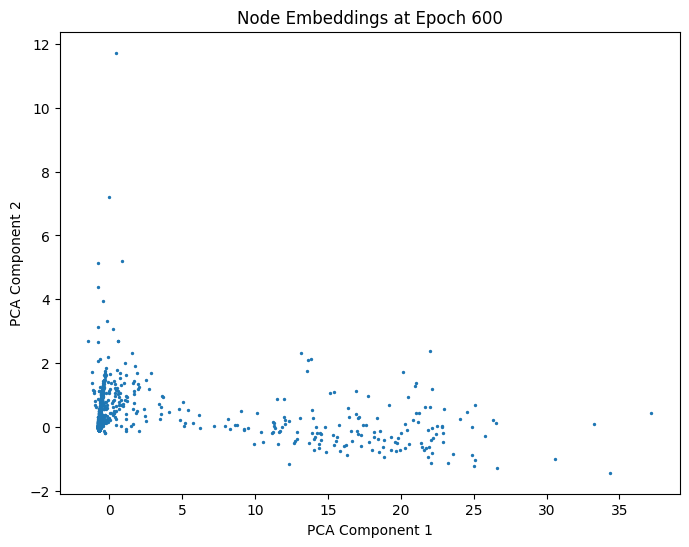

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings, epoch, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=2)
    plt.title(f'{title} Embeddings at Epoch {epoch}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Visualize node embeddings at the last epoch
visualize_embeddings(all_x_embeddings[-1], epochs, 'Node')


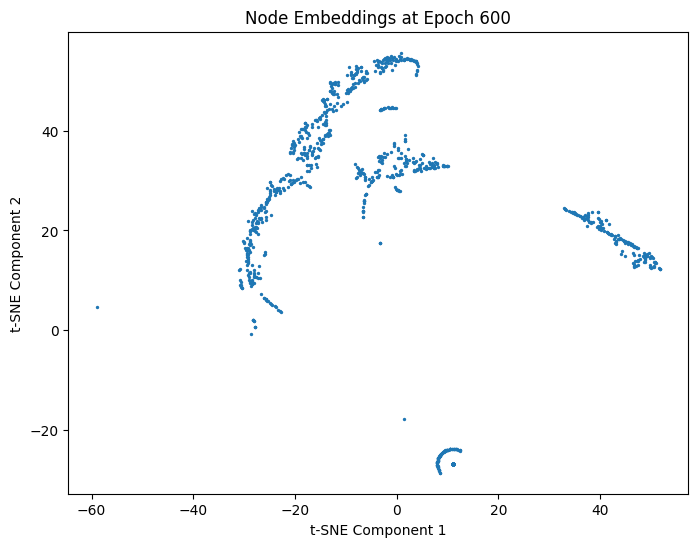

In [15]:
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(embeddings, epoch, title):
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=2)
    plt.title(f'{title} Embeddings at Epoch {epoch}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Visualize node embeddings at the last epoch
visualize_embeddings_tsne(all_x_embeddings[-1], epochs, 'Node')


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, cluster_labels)
    return score

num_clusters = 5
silhouette_score_x = evaluate_clustering(all_x_embeddings[-1], num_clusters)
print(f'Silhouette Score for Node Embeddings: {silhouette_score_x}')


Silhouette Score for Node Embeddings: 0.9150210022926331


In [17]:
def evaluate_reconstruction(x_embeddings, e_embeddings, model, input_data):
    model.eval()
    reconstructed_x = model.decoder_x(torch.tensor(x_embeddings).to(input_data.x.device))
    reconstructed_e = model.decoder_e(torch.tensor(e_embeddings).to(input_data.edge_attr.device))
    
    mse_loss = nn.MSELoss()
    loss_x = mse_loss(reconstructed_x, input_data.x)
    loss_e = mse_loss(reconstructed_e, input_data.edge_attr)
    
    return loss_x.item(), loss_e.item()

loss_x, loss_e = evaluate_reconstruction(all_x_embeddings[-1], all_e_embeddings[-1], model, input_data)
print(f'Reconstruction Loss for Node Features: {loss_x}')
print(f'Reconstruction Loss for Edge Features: {loss_e}')


Reconstruction Loss for Node Features: 0.1188565045595169
Reconstruction Loss for Edge Features: 8993697169408.0
